In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random


In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
sample_playlists = np.random.choice(playlists, 5000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 361662
Number of Artists: 37570


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
#1 Country Classics,1,1
#1 Garth Brooks Tribute Band,1,1
#1 Movie Favorites,1,1
&ME,1,1
'ramblin' jimmie dolan,1,1
...,...,...
Deftones,1159,42
Kanye West,1251,180
David Bowie,1409,146


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 2231


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
2407,944c80d26922ae634d6ce445b1fdff7f,Mat Kearney,All I Have,summer 2012
2408,944c80d26922ae634d6ce445b1fdff7f,Mat Kearney,Annie,summer 2012
2409,944c80d26922ae634d6ce445b1fdff7f,Paul McCartney,Another Day,summer 2012
2410,944c80d26922ae634d6ce445b1fdff7f,Olly Murs,Anywhere Else,summer 2012
2411,944c80d26922ae634d6ce445b1fdff7f,Jack Johnson,Banana Pancakes,summer 2012
...,...,...,...,...
12893684,ec125445f2bdfe5d3d6f49b30dd755b3,Elvis Costello,Painted From Memory - Live,Various Artists – The Best Of Sessions At West...
12893685,ec125445f2bdfe5d3d6f49b30dd755b3,Lou Reed,Set The Twilight Reeling - Live,Various Artists – The Best Of Sessions At West...
12893686,ec125445f2bdfe5d3d6f49b30dd755b3,Sinead O'Connor,The Last Day Of Our Acquaintance - Live,Various Artists – The Best Of Sessions At West...
12893688,ec125445f2bdfe5d3d6f49b30dd755b3,Natalie Merchant,Wonder - Live,Various Artists – The Best Of Sessions At West...


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
12901974,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side,iPhone
12901975,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman,iPhone
12901976,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels,iPhone
12901977,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me,iPhone


In [12]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [13]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 8.77 s, sys: 244 ms, total: 9.01 s
Wall time: 9.13 s


CPU times: user 1min 9s, sys: 1.13 s, total: 1min 10s
Wall time: 1min 10s


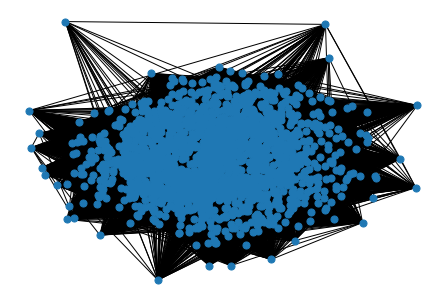

In [14]:
%%time
nx.draw(G, node_size=50)


In [15]:
G.size()

1522916

In [16]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Vampire Weekend' in i:
        weight_dict[i] = node_weights[i]

In [17]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Daft Punk', 'Vampire Weekend'), 43),
 (('Arctic Monkeys', 'Vampire Weekend'), 41),
 (('Arcade Fire', 'Vampire Weekend'), 36),
 (('MGMT', 'Vampire Weekend'), 35),
 (('Phoenix', 'Vampire Weekend'), 35),
 (('Kanye West', 'Vampire Weekend'), 35),
 (('Coldplay', 'Vampire Weekend'), 34),
 (('Vampire Weekend', 'Florence + The Machine'), 34),
 (('Vampire Weekend', 'The xx'), 34),
 (('Vampire Weekend', 'The Strokes'), 31),
 (('Kings Of Leon', 'Vampire Weekend'), 30),
 (('Two Door Cinema Club', 'Vampire Weekend'), 30),
 (('The Killers', 'Vampire Weekend'), 29),
 (('The National', 'Vampire Weekend'), 29),
 (('Radiohead', 'Vampire Weekend'), 28),
 (('Yeah Yeah Yeahs', 'Vampire Weekend'), 28),
 (('Vampire Weekend', 'Muse'), 28),
 (('Bloc Party', 'Vampire Weekend'), 27),
 (('Vampire Weekend', 'The Kooks'), 27),
 (('David Bowie', 'Vampire Weekend'), 26),
 (('Gorillaz', 'Vampire Weekend'), 26),
 (('Justin Timberlake', 'Vampire Weekend'), 26),
 (('Franz Ferdinand', 'Vampire Weekend'), 26),
 (('Vamp

In [18]:
len(G.nodes)

2231

In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artists:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [26]:
%%time
genres = get_artist_genres(list(G.nodes))

CPU times: user 10 s, sys: 1.52 s, total: 11.5 s
Wall time: 4min 51s


In [27]:
genres

{'!!!': ['alternative dance',
  'dance rock',
  'dance-punk',
  'electroclash',
  'electronica',
  'modern rock',
  'new rave',
  'sacramento indie'],
 '10,000 Maniacs': ['lilith', 'mellow gold', 'new wave pop', 'pop rock'],
 '10cc': ['album rock',
  'art rock',
  'blues rock',
  'classic rock',
  'classic uk pop',
  'folk rock',
  'glam rock',
  'mellow gold',
  'rock',
  'soft rock',
  'symphonic rock',
  'yacht rock'],
 '112': ['atl hip hop',
  'boy band',
  'contemporary r&b',
  'dance pop',
  'gangster rap',
  'hip pop',
  'pop rap',
  'r&b',
  'southern hip hop',
  'urban contemporary'],
 '2 Chainz': ['atl hip hop',
  'gangster rap',
  'hip hop',
  'pop rap',
  'rap',
  'southern hip hop',
  'trap'],
 '2Pac': ['g funk', 'gangster rap', 'hip hop', 'rap', 'west coast rap'],
 '3 Doors Down': ['alternative metal', 'nu metal', 'pop rock', 'post-grunge'],
 '311': ['alternative metal',
  'alternative rock',
  'funk metal',
  'funk rock',
  'nu metal',
  'pop rock',
  'rap rock',
  'regg

In [33]:
def filter_dataset(df):
    appearances = df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
    # why are we printing this?
    # print(appearances.sort_values(by=['trackname', 'playlistname']))

    artists = appearances[appearances['playlistname']>=10].index
     # or this?
    # print('# of artists on >= 10 playlists (sample):', len(artists))

    df1 = df[df['artistname'].isin(artists)]

    df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
    playlists = df1_grped[df1_grped['artistname'] > 1].index
    df2 = df1[df1['playlistname'].isin(playlists)]
    print("dataframe filtered")
    return df2